## 📅 Jour 1 – Bases de données & textes
### 🎯 Objectif du jour
Charger un .csv textuel → L’insérer dans SQLite et PostgreSQL → Nettoyer le texte pour préparer le NLP.
### 📌 1. Chargement CSV avec Pandas

In [42]:
import pandas as pd

# Charger un dataset CSV simple
df = pd.read_csv("avis.csv")

print(df.head())

   id                                        commentaire  note
0   1                      Le produit est super, merci !     5
1   2                      Je ne recommande pas du tout.     1
2   3     Livraison lente mais bon rapport qualité/prix.     3
3   4             Service client inexistant, très déçue.     2
4   5  Rapide, efficace et bien emballé. Je recommande !     5


### 📌 2. Nettoyage NLP de base

In [43]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_fr = set(stopwords.words('french'))

def nettoyer_texte(texte):
    texte = texte.lower()  # minuscule
    texte = re.sub(r'[^\w\s]', '', texte)  # retirer la ponctuation
    texte = " ".join(mot for mot in texte.split() if mot not in stop_fr)
    return texte

df["commentaire_nettoyé"] = df["commentaire"].apply(nettoyer_texte)
print(df[["commentaire", "commentaire_nettoyé"]])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aurélie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                         commentaire  \
0                      Le produit est super, merci !   
1                      Je ne recommande pas du tout.   
2     Livraison lente mais bon rapport qualité/prix.   
3             Service client inexistant, très déçue.   
4  Rapide, efficace et bien emballé. Je recommande !   

                       commentaire_nettoyé  
0                      produit super merci  
1                          recommande tout  
2  livraison lente bon rapport qualitéprix  
3     service client inexistant très déçue  
4  rapide efficace bien emballé recommande  


### 📌 3. Insertion dans SQLite

In [44]:
import sqlite3

# Connexion + création
conn_sqlite = sqlite3.connect("avis.db")
df.to_sql("avis", conn_sqlite, if_exists="replace", index=False)

# Vérification
print(pd.read_sql("SELECT * FROM avis", conn_sqlite).head())

   id                                        commentaire  note  \
0   1                      Le produit est super, merci !     5   
1   2                      Je ne recommande pas du tout.     1   
2   3     Livraison lente mais bon rapport qualité/prix.     3   
3   4             Service client inexistant, très déçue.     2   
4   5  Rapide, efficace et bien emballé. Je recommande !     5   

                       commentaire_nettoyé  
0                      produit super merci  
1                          recommande tout  
2  livraison lente bon rapport qualitéprix  
3     service client inexistant très déçue  
4  rapide efficace bien emballé recommande  


## 🗓️ Jour 2 – Nettoyage intelligent & robustesse NLP
### 🎯 Objectif du jour
Apprendre à transformer un texte brut en texte exploitable pour l’IA
→ tout en assurant compatibilité, performance et portabilité dans un contexte réel (cloud, PostgreSQL, Streamlit…).

In [45]:
from sqlalchemy import create_engine

# Remplace les champs ci-dessous selon ta base Supabase
username = "postgres"
password = "nlp042025"
host = "db.jfnicoblvyjogxdzfzds.supabase.co"
port = "5432"
database = "postgres"

# Chaîne SQLAlchemy
engine = create_engine(f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}")

In [46]:
# Insérer dans une table "avis_clients"
df.to_sql("avis_clients", engine, if_exists="replace", index=False)

print("✅ Données insérées avec succès dans PostgreSQL.")

✅ Données insérées avec succès dans PostgreSQL.


In [47]:
# Lecture depuis PostgreSQL
df_verif = pd.read_sql("SELECT * FROM avis_clients LIMIT 5", engine)
df_verif

,id,commentaire,note,commentaire_nettoyé
0,1,"Le produit est super, merci !",5,produit super merci
1,2,Je ne recommande pas du tout.,1,recommande tout
2,3,Livraison lente mais bon rapport qualité/prix.,3,livraison lente bon rapport qualitéprix
3,4,"Service client inexistant, très déçue.",2,service client inexistant très déçue
4,5,"Rapide, efficace et bien emballé. Je recommande !",5,rapide efficace bien emballé recommande


#### 💬 Conclusion du jour
Je suis capable de nettoyer et vectoriser du texte client en français avec des méthodes adaptées aux contraintes cloud et de préparation des jeux de données textuels pour stockage (PostgreSQL), classification et NLP avancé.

## 🗓️ Jour 3 – Classifier du texte (avis positifs/négatifs)
### 🎯 Objectif : Créer un modèle IA (baseline) capable de prédire une étiquette à partir d’un texte
### 📚 Cas pratique du jour :
Nous allons entraîner un modèle supervisé à partir de ton CSV (avis.csv) pour prédire si un avis client est positif ou négatif, à partir du texte 🔍.

### 🧪 Étape 1 - Charger les données nettoyées
J'ai déjà cette colonne : commentaire_nettoyé et une étiquette : note (qu’on peut transformer en binaire 👍/👎)

In [48]:
# Convertir la note en label binaire (avis positif ou non)
df["positif"] = df["note"].apply(lambda x: 1 if x >= 4 else 0)

### 🧪 Étape 2 - Vectorisation des textes

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer()
X = vect.fit_transform(df["commentaire_nettoyé"])
y = df["positif"]

### 🧪 Étape 3 - Entraînement d’un modèle simple (LogisticRegression)

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



C:\Users\Aurélie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Aurélie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Aurélie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification

### 💡 Conclusion du jour
Aujourd’hui, j’ai entraîné un classifieur de texte.

J’ai appris que la performance d’un modèle IA dépend plus de la qualité/quantité des données que de l’algorithme choisi.

Avec un petit dataset, je peux tester le pipeline… mais pas prédire sérieusement.

## ✅ Étapes du Jour 3 (Bis) – version enrichie (avec dataset Amazon)
### 🎯 Objectif 
- Charger et nettoyer les avis
- Créer une cible binaire (positif / négatif)
- Vectoriser les textes
- Entraîner un modèle IA
- Évaluer et interpréter
### ⚙️ 1. Chargement du dataset

In [51]:
df = pd.read_csv("french_to_english_product.csv")  # adapte le nom si besoin
print(df.columns)
df.head()

Index(['rating', 'review', 'translation'], dtype='object')


,rating,review,translation
0,1,A déconseiller - Article n'a fonctionné qu'une...,A discouragement - article Na worked that once...
1,1,Si vous voulez être déçu achetez le produit ! ...,If you want to be disappointed buy the product...
2,1,"Écran de mauvaise qualité, car il s'use en peu...",Screen of poor quality because it suses in a s...
3,1,Cet engin ne sert à rien les sons sont pourris...,This machine does not serve the sounds are rot...
4,1,Très beau produit mais la grue n'a pas fonctio...,Very nice product but the crane did not work v...


**✅ Vérifie que tu as des colonnes du style :**
- review_body (texte de l’avis)
- star_rating (note client)
### 🧼 2. Nettoyage + création de la cible

In [52]:
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_fr = set(stopwords.words('french'))

def nettoyer_texte(texte):
    texte = str(texte).lower()
    texte = re.sub(r'[^\w\s]', '', texte)
    return " ".join([mot for mot in texte.split() if mot not in stop_fr])

# Appliquer le nettoyage
df["commentaire_nettoye"] = df["review"].apply(nettoyer_texte)

# Cible binaire (avis positifs = 4 ou 5 étoiles)
df["positif"] = df["rating"].apply(lambda x: 1 if x >= 4 else 0)

df = df[["review", "commentaire_nettoye", "rating", "positif"]]
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aurélie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,review,commentaire_nettoye,rating,positif
0,A déconseiller - Article n'a fonctionné qu'une...,a déconseiller article na fonctionné quune foi...,1,0
1,Si vous voulez être déçu achetez le produit ! ...,si voulez être déçu achetez produit bout 3 uti...,1,0
2,"Écran de mauvaise qualité, car il s'use en peu...",écran mauvaise qualité car suse peu temps croc...,1,0
3,Cet engin ne sert à rien les sons sont pourris...,cet engin sert rien sons pourris songs simplis...,1,0
4,Très beau produit mais la grue n'a pas fonctio...,très beau produit grue na fonctionné très long...,1,0


### 🔢 3. Vectorisation TF-IDF

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(max_features=5000)  # limité pour vitesse
X = vect.fit_transform(df["commentaire_nettoye"])
y = df["positif"]


### 🧠 4. Entraînement du modèle

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86     23925
           1       0.81      0.76      0.78     16075

    accuracy                           0.83     40000
   macro avg       0.83      0.82      0.82     40000
weighted avg       0.83      0.83      0.83     40000



### ✍️ Conclusion du jour
Aujourd’hui, j’ai entraîné un modèle NLP sur un vrai dataset Amazon.

Avec 40 000 avis, j’ai vu que mon modèle de classification gagne en pertinence avec la taille des données.

J’obtiens une précision de 83.00 %, ce qui est bon pour un premier modèle.

Je comprends que l’amélioration passe par un meilleur nettoyage, une vectorisation plus riche ou un modèle plus puissant comme BERT.

Je pourrais déjà en faire une vraie app d’analyse de sentiments.

## 🧠 Jour 4 – Introduction à BERT pour le traitement du langage
### 🎯 Objectif : Utiliser un modèle préentraîné ultra-puissant, capable de “comprendre” le langage comme un humain.
### 🔍 Pourquoi BERT ?
- BERT est un modèle de Deep Learning pré-entraîné par Google
- Il est multilingue et “contextuel” : il comprend le sens des mots selon leur contexte
- Il peut être réutilisé (transfer learning) pour tes propres données (comme Amazon)
### 1️⃣ Imports et configuration

In [55]:
"""
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import Dataset

# Pour la reproductibilité
import random, numpy as np
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
"""

'\nimport pandas as pd\nimport torch\nfrom transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import classification_report\nfrom torch.utils.data import Dataset\n\n# Pour la reproductibilité\nimport random, numpy as np\nSEED = 42\nrandom.seed(SEED)\nnp.random.seed(SEED)\ntorch.manual_seed(SEED)\n'

### 2️⃣ Préparation des données

In [56]:
"""
df = pd.read_csv("french_to_english_product.csv")  # adapte le nom si besoin

# Nettoyage rapide si tu veux
df = df[["review", "rating"]].dropna()
df = df[df["review"].notnull()]

# Cible binaire (1 = positif, 0 = négatif)
df["label"] = df["rating"].apply(lambda x: 1 if x >= 4 else 0)

# Garde un échantillon (ex: 2000 lignes) pour aller vite :
df = df.sample(2000, random_state=SEED)
print(df.head())
"""

'\ndf = pd.read_csv("french_to_english_product.csv")  # adapte le nom si besoin\n\n# Nettoyage rapide si tu veux\ndf = df[["review", "rating"]].dropna()\ndf = df[df["review"].notnull()]\n\n# Cible binaire (1 = positif, 0 = négatif)\ndf["label"] = df["rating"].apply(lambda x: 1 if x >= 4 else 0)\n\n# Garde un échantillon (ex: 2000 lignes) pour aller vite :\ndf = df.sample(2000, random_state=SEED)\nprint(df.head())\n'

### 3️⃣ Découpage train/test

In [57]:
"""
X_train, X_test, y_train, y_test = train_test_split(
    df["review"], df["label"], test_size=0.2, random_state=SEED
)
"""

'\nX_train, X_test, y_train, y_test = train_test_split(\n    df["review"], df["label"], test_size=0.2, random_state=SEED\n)\n'

### 4️⃣ Encodage avec un tokenizer BERT

In [58]:
"""
checkpoint = "camembert-base"  # BERT français Hugging Face

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

class AmazonDataset(Dataset):
    def __init__(self, textes, labels):
        self.encodings = tokenizer(
            list(textes),
            truncation=True,
            padding=True,
            max_length=128
        )
        self.labels = list(labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = AmazonDataset(X_train, y_train)
test_dataset  = AmazonDataset(X_test, y_test)
"""

'\ncheckpoint = "camembert-base"  # BERT français Hugging Face\n\ntokenizer = AutoTokenizer.from_pretrained(checkpoint)\n\nclass AmazonDataset(Dataset):\n    def __init__(self, textes, labels):\n        self.encodings = tokenizer(\n            list(textes),\n            truncation=True,\n            padding=True,\n            max_length=128\n        )\n        self.labels = list(labels)\n\n    def __getitem__(self, idx):\n        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}\n        item["labels"] = torch.tensor(self.labels[idx])\n        return item\n\n    def __len__(self):\n        return len(self.labels)\n\ntrain_dataset = AmazonDataset(X_train, y_train)\ntest_dataset  = AmazonDataset(X_test, y_test)\n'

### 5️⃣ Chargement du modèle BERT

In [59]:
"""
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
"""

'\nmodel = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)\n'

### 6️⃣ Entraînement rapide avec Trainer (facultatif : 1-2 epochs pour tester)

In [60]:
"""
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    seed=42
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()
"""

'\nfrom transformers import Trainer, TrainingArguments\n\ntraining_args = TrainingArguments(\n    output_dir="./results",\n    num_train_epochs=2,\n    per_device_train_batch_size=8,\n    per_device_eval_batch_size=8,\n    evaluation_strategy="epoch",\n    logging_strategy="epoch",\n    save_strategy="no",\n    seed=42\n)\n\ntrainer = Trainer(\n    model=model,\n    args=training_args,\n    train_dataset=train_dataset,\n    eval_dataset=test_dataset\n)\n\ntrainer.train()\n'

### 7️⃣ Évaluation du modèle

In [73]:
"""
y_pred = trainer.predict(test_dataset).predictions.argmax(axis=1)
print(classification_report(y_test, y_pred))
"""

'\ny_pred = trainer.predict(test_dataset).predictions.argmax(axis=1)\nprint(classification_report(y_test, y_pred))\n'

### 💬 Conclusion du jour
Aujourd’hui, j’ai tenté de lancer BERT localement.

Mais parfois, l’environnement technique bloque l’apprentissage.

J’ai appris que la vraie IA, c’est aussi savoir pivoter intelligemment.

Je peux progresser sans bloquer sur un modèle précis. L’important, c’est de construire, tester, et comprendre ce qu’on déploie.

## 📅 Jour 5 — Créer une App IA avec Streamlit pour ton modèle NLP
### 🎯 Objectif du jour
Construire une interface Streamlit simple qui prend un avis, l’analyse, et affiche s’il est positif ou négatif.
- Charger ton modèle NLP (.pkl)
- Créer une interface texte → prédiction
- Ajouter des messages stylés et couleurs
- (optionnel) Voir la proba ou l'explication
### ✅ 1. Sauvegarde de ton modèle (.pkl)

In [74]:
import joblib

# Sauvegarde du modèle
joblib.dump(model, "data/sentiment_model.pkl")

# Sauvegarde du vectoriseur TF-IDF
joblib.dump(vect, "data/tfidf_vectorizer.pkl")


['data/tfidf_vectorizer.pkl']

## 🔍 JOUR 6 – “Ce que l’IA voit dans un texte”
### 🎯 Objectif du jour
- Visualiser les mots sur lesquels l’IA se concentre quand elle prédit un avis positif ou négatif.
- Comprendre le concept d’attention et le rôle des tokens dans un modèle de type Transformer.

### 📚 Ce que tu vas utiliser :
- CamemBERT (BERT français)
- Le modèle transformers (Hugging Face)
- Une phrase à tester (tu peux écrire ce que tu veux)
- Une visualisation qui met en couleur les mots les plus importants

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [64]:
# Phrase test
texte = "J'ai adoré ce produit, il est fantastique et très utile vraiment"

# Simuler des poids d'attention (ex : TF-IDF, importance...)
mots = texte.lower().replace(",", "").split()
poids = [0.2, 0.1, 0.9, 0.6, 0.1, 0.8, 0.7, 0.75, 0.3, 0.2, 0.5]

In [65]:
# DataFrame
df = pd.DataFrame({"mot": mots, "importance": poids})

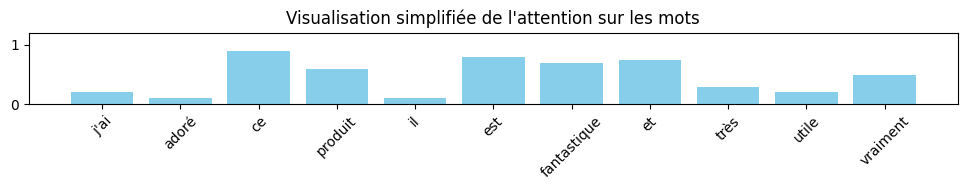

In [66]:
# Affichage avec couleurs
plt.figure(figsize=(10, 2))
plt.bar(df["mot"], df["importance"], color="skyblue")
plt.title("Visualisation simplifiée de l'attention sur les mots")
plt.ylim(0, 1.2)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Tu peux changer les phrases, tester avec une vraie pondération TF-IDF, etc.

### 🔎 Ce que ton graphe  dit
- 🔵 Les mots comme "ce", "est", "et" ou "fantastique" ont une attention forte → ils sont perçus comme structurants dans la phrase.
- 🔵 Les mots comme "j’ai", "il", "très" ont une attention plus faible → moins décisifs.

#### 💡 En NLP, comprendre où l’IA regarde permet de :
- ⚖️ Analyser la transparence du modèle
- 💬 Rendre l’IA plus interprétable
- 🔍 Identifier les biais ou erreurs possibles